In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_curve, auc
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt

# -------------------
# Load CSV
# -------------------
df = pd.read_csv('combined_crop_disease_labels.csv')
df['label_encoded'] = pd.factorize(df['label'])[0]
df['label_str'] = df['label'].astype(str)  # For ImageDataGenerator

# Parameters
IMG_SIZE = (256, 256)
BATCH_SIZE = 32
EPOCHS = 20
N_SPLITS = 5

# -------------------
# CNN Model Builder
# -------------------
def build_cnn_model(input_shape=(256, 256, 3), num_classes=None):
    model = models.Sequential([
        layers.Input(shape=input_shape),
        layers.Conv2D(32, (3,3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D(2),
        layers.Conv2D(64, (3,3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D(2),
        layers.Conv2D(128, (3,3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D(2),
        layers.GlobalAveragePooling2D(),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation='softmax')
    ])
    model.compile(optimizer=Adam(learning_rate=0.001),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model

In [2]:
# -------------------
# K-Fold Cross Validation
# -------------------
skf = StratifiedKFold(n_splits=N_SPLITS, shuffle=True, random_state=42)
fold_no = 1
acc_per_fold = []
loss_per_fold = []

# For ROC curve plotting later
roc_data = []

for train_idx, val_idx in skf.split(df, df['label_encoded']):
    print(f"\n===== Fold {fold_no} =====")
    
    train_df = df.iloc[train_idx]
    val_df = df.iloc[val_idx]
    
    # Generators
    train_datagen = ImageDataGenerator(rescale=1./255)
    val_datagen = ImageDataGenerator(rescale=1./255)
    
    train_gen = train_datagen.flow_from_dataframe(
        dataframe=train_df,
        x_col='image_path',
        y_col='label_str',
        target_size=IMG_SIZE,
        batch_size=BATCH_SIZE,
        class_mode='categorical',
        shuffle=True
    )
    
    val_gen = val_datagen.flow_from_dataframe(
        dataframe=val_df,
        x_col='image_path',
        y_col='label_str',
        target_size=IMG_SIZE,
        batch_size=BATCH_SIZE,
        class_mode='categorical',
        shuffle=False
    )
    
    # Build & train model
    model = build_cnn_model(input_shape=(256, 256, 3),
                            num_classes=len(train_gen.class_indices))
    
    early_stop = EarlyStopping(monitor='val_loss', patience=4, restore_best_weights=True)
    
    history = model.fit(
        train_gen,
        validation_data=val_gen,
        epochs=EPOCHS,
        callbacks=[early_stop],
        verbose=1
    )
 
    # Save model
    model.save(f"model_5_fold_{fold_no}.keras")
    
    # Evaluate
    scores = model.evaluate(val_gen, verbose=0)
    print(f"Fold {fold_no} - Loss: {scores[0]:.4f}, Accuracy: {scores[1]*100:.2f}%")
    acc_per_fold.append(scores[1])
    loss_per_fold.append(scores[0])
    
    # Predictions for ROC
    y_pred = model.predict(val_gen)
    y_true = val_gen.classes
    class_labels = list(val_gen.class_indices.keys())
    
    # Compute ROC for each class
    from sklearn.preprocessing import label_binarize
    y_true_bin = label_binarize(y_true, classes=np.arange(len(class_labels)))
    
    for i in range(len(class_labels)):
        fpr, tpr, _ = roc_curve(y_true_bin[:, i], y_pred[:, i])
        roc_auc = auc(fpr, tpr)
        roc_data.append((fold_no, class_labels[i], fpr, tpr, roc_auc))
    
    fold_no += 1


===== Fold 1 =====
Found 38789 validated image filenames belonging to 26 classes.
Found 9698 validated image filenames belonging to 26 classes.


2025-08-11 08:07:19.569965: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1 Max
2025-08-11 08:07:19.570000: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 32.00 GB
2025-08-11 08:07:19.570005: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 10.67 GB
2025-08-11 08:07:19.570021: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-08-11 08:07:19.570035: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
/Users/simarkalsi/Projects/General Classification/disease/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` clas

Epoch 1/20


2025-08-11 08:07:21.113248: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


1213/1213 ━━━━━━━━━━━━━━━━━━━━ 138s 109ms/step - accuracy: 0.3919 - loss: 1.9770 - val_accuracy: 0.4906 - val_loss: 1.6361
Epoch 2/20
1213/1213 ━━━━━━━━━━━━━━━━━━━━ 131s 108ms/step - accuracy: 0.6401 - loss: 1.0775 - val_accuracy: 0.4865 - val_loss: 1.7302
Epoch 3/20
1213/1213 ━━━━━━━━━━━━━━━━━━━━ 135s 111ms/step - accuracy: 0.7118 - loss: 0.8607 - val_accuracy: 0.7531 - val_loss: 0.7580
Epoch 4/20
1213/1213 ━━━━━━━━━━━━━━━━━━━━ 131s 108ms/step - accuracy: 0.7558 - loss: 0.7290 - val_accuracy: 0.7428 - val_loss: 0.7660
Epoch 5/20
1213/1213 ━━━━━━━━━━━━━━━━━━━━ 130s 107ms/step - accuracy: 0.7769 - loss: 0.6651 - val_accuracy: 0.7085 - val_loss: 0.8409
Epoch 6/20
1213/1213 ━━━━━━━━━━━━━━━━━━━━ 130s 107ms/step - accuracy: 0.7973 - loss: 0.6019 - val_accuracy: 0.8411 - val_loss: 0.4673
Epoch 7/20
1213/1213 ━━━━━━━━━━━━━━━━━━━━ 130s 107ms/step - accuracy: 0.8100 - loss: 0.5779 - val_accuracy: 0.8014 - val_loss: 0.5898
Epoch 8/20
1213/1213 ━━━━━━━━━━━━━━━━━━━━ 132s 108ms/step - accuracy: 0.8

/Users/simarkalsi/Projects/General Classification/disease/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1213/1213 ━━━━━━━━━━━━━━━━━━━━ 136s 111ms/step - accuracy: 0.3945 - loss: 1.9914 - val_accuracy: 0.5594 - val_loss: 1.3537
Epoch 2/20
1213/1213 ━━━━━━━━━━━━━━━━━━━━ 134s 110ms/step - accuracy: 0.6517 - loss: 1.0415 - val_accuracy: 0.5651 - val_loss: 1.5146
Epoch 3/20
1213/1213 ━━━━━━━━━━━━━━━━━━━━ 134s 111ms/step - accuracy: 0.7237 - loss: 0.8094 - val_accuracy: 0.6381 - val_loss: 1.2648
Epoch 4/20
1213/1213 ━━━━━━━━━━━━━━━━━━━━ 134s 111ms/step - accuracy: 0.7597 - loss: 0.7058 - val_accuracy: 0.7878 - val_loss: 0.6400
Epoch 5/20
1213/1213 ━━━━━━━━━━━━━━━━━━━━ 134s 111ms/step - accuracy: 0.7853 - loss: 0.6383 - val_accuracy: 0.7207 - val_loss: 0.8948
Epoch 6/20
1213/1213 ━━━━━━━━━━━━━━━━━━━━ 134s 110ms/step - accuracy: 0.8033 - loss: 0.5880 - val_accuracy: 0.7675 - val_loss: 0.7056
Epoch 7/20
1213/1213 ━━━━━━━━━━━━━━━━━━━━ 134s 111ms/step - accuracy: 0.8121 - loss: 0.5601 - val_accuracy: 0.7571 - val_loss: 0.7963
Epoch 8/20
1213/1213 ━━━━━━━━━━━━━━━━━━━━ 134s 110ms/step - accuracy: 0.8

/Users/simarkalsi/Projects/General Classification/disease/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1213/1213 ━━━━━━━━━━━━━━━━━━━━ 133s 108ms/step - accuracy: 0.4014 - loss: 1.9529 - val_accuracy: 0.5296 - val_loss: 1.4827
Epoch 2/20
1213/1213 ━━━━━━━━━━━━━━━━━━━━ 130s 107ms/step - accuracy: 0.6440 - loss: 1.0665 - val_accuracy: 0.7127 - val_loss: 0.8548
Epoch 3/20
1213/1213 ━━━━━━━━━━━━━━━━━━━━ 133s 110ms/step - accuracy: 0.7186 - loss: 0.8371 - val_accuracy: 0.6511 - val_loss: 1.2484
Epoch 4/20
1213/1213 ━━━━━━━━━━━━━━━━━━━━ 129s 106ms/step - accuracy: 0.7473 - loss: 0.7479 - val_accuracy: 0.6767 - val_loss: 1.0379
Epoch 5/20
1213/1213 ━━━━━━━━━━━━━━━━━━━━ 129s 107ms/step - accuracy: 0.7781 - loss: 0.6638 - val_accuracy: 0.5932 - val_loss: 1.6899
Epoch 6/20
1213/1213 ━━━━━━━━━━━━━━━━━━━━ 129s 106ms/step - accuracy: 0.7926 - loss: 0.6200 - val_accuracy: 0.7941 - val_loss: 0.6318
Epoch 7/20
1213/1213 ━━━━━━━━━━━━━━━━━━━━ 129s 106ms/step - accuracy: 0.8086 - loss: 0.5738 - val_accuracy: 0.8134 - val_loss: 0.5649
Epoch 8/20
1213/1213 ━━━━━━━━━━━━━━━━━━━━ 129s 107ms/step - accuracy: 0.8

/Users/simarkalsi/Projects/General Classification/disease/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1213/1213 ━━━━━━━━━━━━━━━━━━━━ 131s 107ms/step - accuracy: 0.3975 - loss: 1.9500 - val_accuracy: 0.6180 - val_loss: 1.1342
Epoch 2/20
1213/1213 ━━━━━━━━━━━━━━━━━━━━ 129s 106ms/step - accuracy: 0.6535 - loss: 1.0403 - val_accuracy: 0.7482 - val_loss: 0.7318
Epoch 3/20
1213/1213 ━━━━━━━━━━━━━━━━━━━━ 129s 106ms/step - accuracy: 0.7245 - loss: 0.8236 - val_accuracy: 0.6577 - val_loss: 1.0883
Epoch 4/20
1213/1213 ━━━━━━━━━━━━━━━━━━━━ 128s 106ms/step - accuracy: 0.7603 - loss: 0.7263 - val_accuracy: 0.6331 - val_loss: 1.2221
Epoch 5/20
1213/1213 ━━━━━━━━━━━━━━━━━━━━ 128s 106ms/step - accuracy: 0.7865 - loss: 0.6438 - val_accuracy: 0.7732 - val_loss: 0.6839
Epoch 6/20
1213/1213 ━━━━━━━━━━━━━━━━━━━━ 129s 106ms/step - accuracy: 0.8038 - loss: 0.5896 - val_accuracy: 0.8054 - val_loss: 0.5666
Epoch 7/20
1213/1213 ━━━━━━━━━━━━━━━━━━━━ 129s 106ms/step - accuracy: 0.8086 - loss: 0.5675 - val_accuracy: 0.8143 - val_loss: 0.5727
Epoch 8/20
1213/1213 ━━━━━━━━━━━━━━━━━━━━ 129s 106ms/step - accuracy: 0.8

/Users/simarkalsi/Projects/General Classification/disease/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1213/1213 ━━━━━━━━━━━━━━━━━━━━ 131s 107ms/step - accuracy: 0.3987 - loss: 1.9797 - val_accuracy: 0.3672 - val_loss: 2.2078
Epoch 2/20
1213/1213 ━━━━━━━━━━━━━━━━━━━━ 129s 106ms/step - accuracy: 0.6465 - loss: 1.0463 - val_accuracy: 0.5347 - val_loss: 1.5591
Epoch 3/20
1213/1213 ━━━━━━━━━━━━━━━━━━━━ 129s 106ms/step - accuracy: 0.7157 - loss: 0.8453 - val_accuracy: 0.6895 - val_loss: 0.9708
Epoch 4/20
1213/1213 ━━━━━━━━━━━━━━━━━━━━ 129s 106ms/step - accuracy: 0.7494 - loss: 0.7477 - val_accuracy: 0.6190 - val_loss: 1.1951
Epoch 5/20
1213/1213 ━━━━━━━━━━━━━━━━━━━━ 129s 106ms/step - accuracy: 0.7784 - loss: 0.6677 - val_accuracy: 0.7945 - val_loss: 0.6971
Epoch 6/20
1213/1213 ━━━━━━━━━━━━━━━━━━━━ 129s 106ms/step - accuracy: 0.7948 - loss: 0.6218 - val_accuracy: 0.7195 - val_loss: 0.9365
Epoch 7/20
1213/1213 ━━━━━━━━━━━━━━━━━━━━ 129s 106ms/step - accuracy: 0.8074 - loss: 0.5807 - val_accuracy: 0.7735 - val_loss: 0.7300
Epoch 8/20
1213/1213 ━━━━━━━━━━━━━━━━━━━━ 129s 107ms/step - accuracy: 0.8


=== Cross-validation results ===
Fold 1 - Loss: 0.4321, Accuracy: 86.03%
Fold 2 - Loss: 0.4054, Accuracy: 86.51%
Fold 3 - Loss: 0.5649, Accuracy: 81.34%
Fold 4 - Loss: 0.3831, Accuracy: 87.77%
Fold 5 - Loss: 0.4433, Accuracy: 85.04%

Average Accuracy: 85.34%
Average Loss: 0.4457


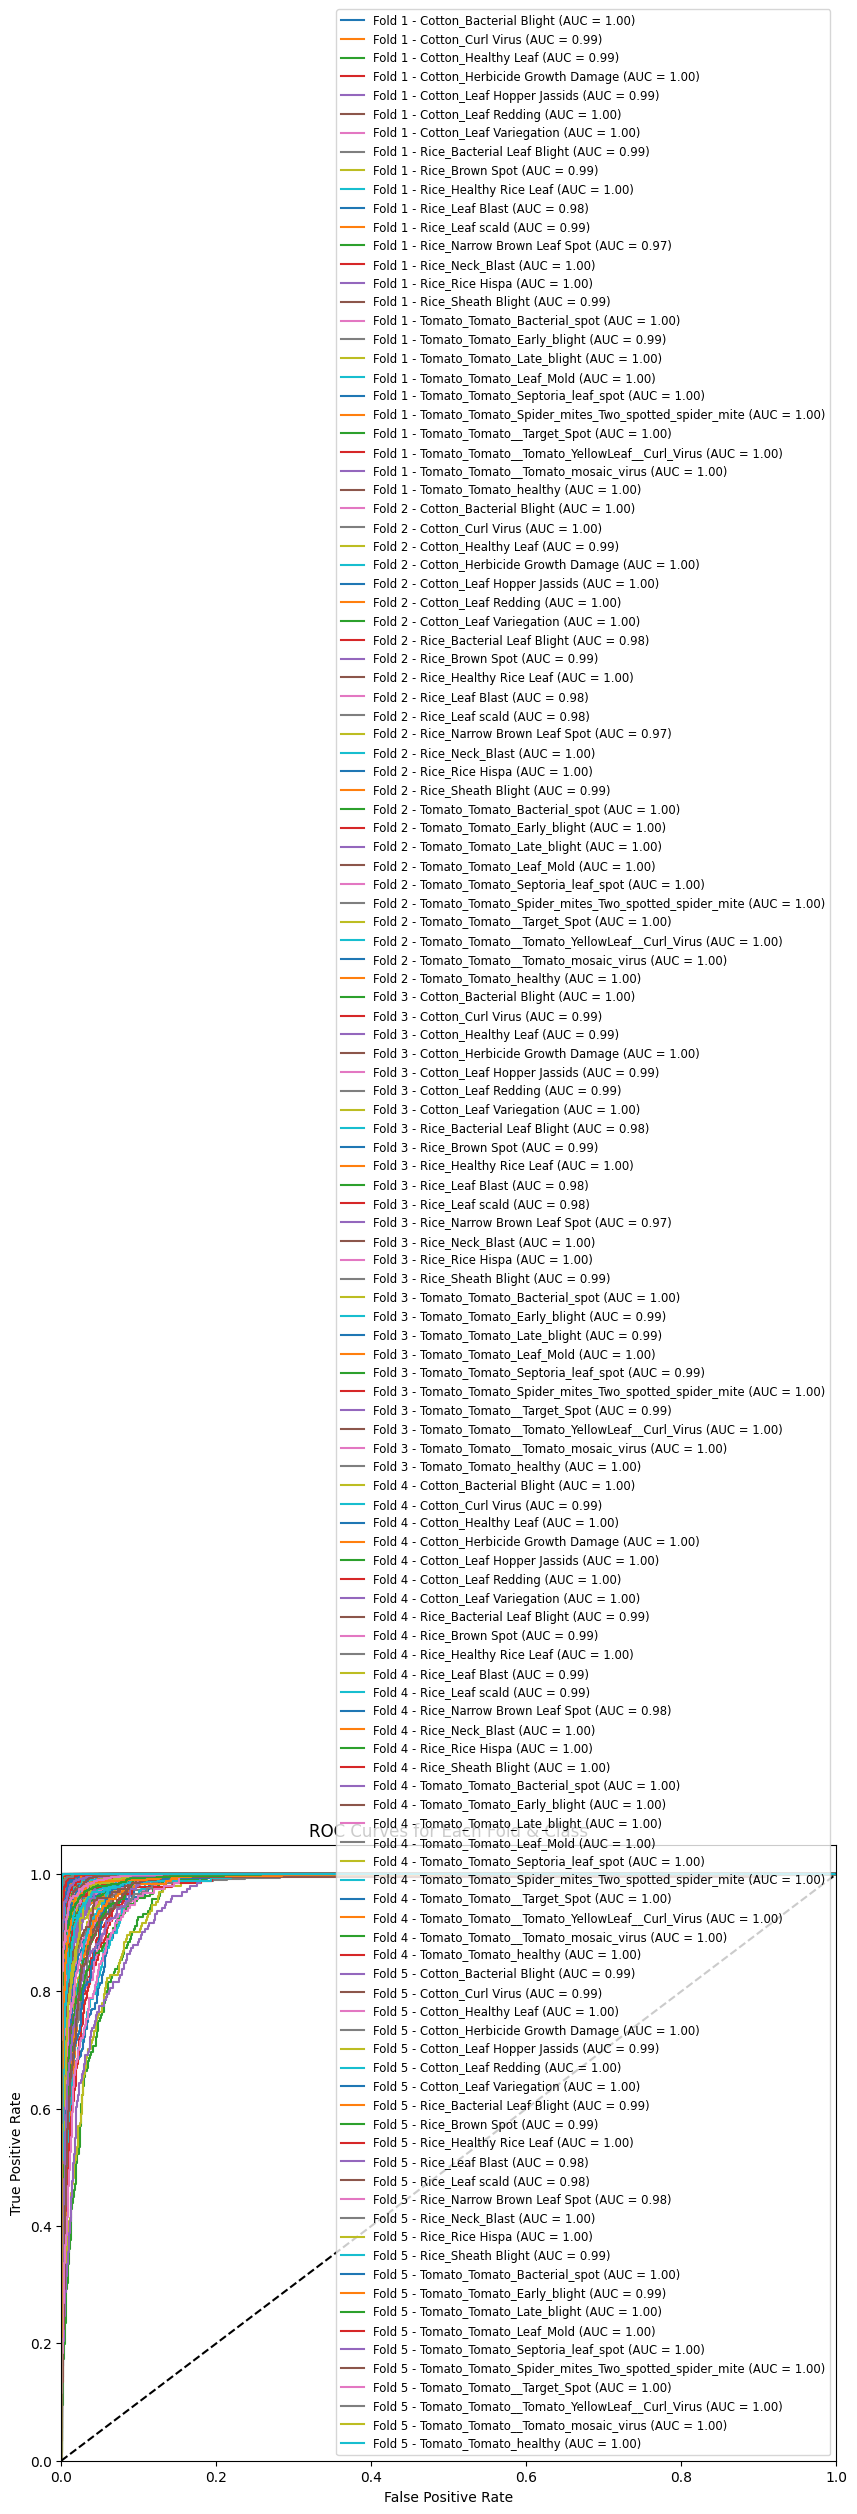

In [3]:
# -------------------
# Results Summary
# -------------------
print("\n=== Cross-validation results ===")
for i in range(len(acc_per_fold)):
    print(f"Fold {i+1} - Loss: {loss_per_fold[i]:.4f}, Accuracy: {acc_per_fold[i]*100:.2f}%")

print(f"\nAverage Accuracy: {np.mean(acc_per_fold)*100:.2f}%")
print(f"Average Loss: {np.mean(loss_per_fold):.4f}")

# -------------------
# Plot ROC curves for all folds
# -------------------
plt.figure(figsize=(10, 8))
for fold, cls, fpr, tpr, roc_auc in roc_data:
    plt.plot(fpr, tpr, label=f'Fold {fold} - {cls} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for Each Fold & Class')
plt.legend(loc='lower right', fontsize='small')
plt.show()